In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split


### Preprocessing data

In [59]:
music = pd.read_csv("music_clean.csv")

music.head()

,Unnamed: 0,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,genre
0,36506,60.0,0.896000,0.726,214547.0,0.177,0.000002,0.1160,-14.824,0.0353,92.934,0.618,1
1,37591,63.0,0.003840,0.635,190448.0,0.908,0.083400,0.2390,-4.795,0.0563,110.012,0.637,1
2,37658,59.0,0.000075,0.352,456320.0,0.956,0.020300,0.1250,-3.634,0.1490,122.897,0.228,1
3,36060,54.0,0.945000,0.488,352280.0,0.326,0.015700,0.1190,-12.020,0.0328,106.063,0.323,1
4,35710,55.0,0.245000,0.667,273693.0,0.647,0.000297,0.0633,-7.787,0.0487,143.995,0.300,1


In [60]:
music_dummies = pd.get_dummies(music['genre'], drop_first=True)


music_dummies_concat = pd.concat([music, music_dummies], axis=1)
music_dummies_concat.drop("genre", axis=1)

,Unnamed: 0,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,1
0,36506,60.0,0.896000,0.726,214547.0,0.1770,0.000002,0.1160,-14.824,0.0353,92.934,0.6180,True
1,37591,63.0,0.003840,0.635,190448.0,0.9080,0.083400,0.2390,-4.795,0.0563,110.012,0.6370,True
2,37658,59.0,0.000075,0.352,456320.0,0.9560,0.020300,0.1250,-3.634,0.1490,122.897,0.2280,True
3,36060,54.0,0.945000,0.488,352280.0,0.3260,0.015700,0.1190,-12.020,0.0328,106.063,0.3230,True
4,35710,55.0,0.245000,0.667,273693.0,0.6470,0.000297,0.0633,-7.787,0.0487,143.995,0.3000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,44501,57.0,0.972000,0.193,208040.0,0.0329,0.929000,0.0978,-28.228,0.0460,82.165,0.0366,False
996,25114,56.0,0.005790,0.939,144453.0,0.3730,0.000000,0.2740,-7.779,0.2270,119.953,0.0602,False
997,46896,54.0,0.016100,0.739,238339.0,0.5390,0.000000,0.2350,-9.735,0.3370,85.082,0.8350,False
998,45135,62.0,0.326000,0.515,286707.0,0.5050,0.000000,0.1020,-5.606,0.0294,150.063,0.5380,False


In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

X = music.drop('popularity', axis=1).values
y = music['popularity'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

kf= KFold(n_splits=5, shuffle=True, random_state=42)

lingred= LinearRegression()
lingred_cv = cross_val_score(lingred, X_train, y_train, cv=kf, scoring="neg_mean_squared_error") #sklearn assume high score is better

print(np.sqrt(-lingred_cv))

[ 8.54974458 10.30548473 10.485822   10.32767843  9.32783382]


### Handling missing data

In [62]:
music.isna().sum().sort_values() #calculate the number of na

Unnamed: 0          0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
genre               0
dtype: int64

#### remove missing value

In [63]:
music = music.dropna(subset=["genre", "popularity", "loudness", "liveness", "tempo"]) #if missing values in subset column, the entire row is removed

#### Inputing values

* Common use mean
* Can also use the median, or another value
* For categorical value, we can use the most frequent value


In [64]:
from sklearn.impute import SimpleImputer

X_cat = music["genre"].values.reshape(-1, 1)
X_num = music.drop(["genre", "popularity"], axis=1).values

y = music["popularity"].values

X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_cat, y, test_size=0.3, random_state=42)
X_train_num, X_test_num, y_train, y_test = train_test_split(X_num, y, test_size=0.3, random_state=42)

imp_cat = SimpleImputer(strategy="most_frequent")
X_train_cat = imp_cat.fit_transform(X_train_cat)
X_test_cat = imp_cat.transform(X_test_cat)

imp_num = SimpleImputer() #default is mean
X_train_num = imp_num.fit_transform(X_train_num)
X_test_num = imp_num.transform(X_test_num)

X_train = np.append(X_train_num, X_train_cat, axis=1)
X_test = np.append(X_test_num, X_test_cat, axis=1)

#### Imputing within a pipeline


In [65]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
music = music.dropna(subset=['genre', 'popularity', 'loudness', 'liveness', 'tempo'])

# music['genre'] = np.where(music['genre'] == "Rock", 1, 0)
X = music.drop("genre", axis=1).values
y = music['genre'].values

steps = [("imputation", SimpleImputer()),
         ("logistic_regression", LogisticRegression())
]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


pipeline = Pipeline(steps) #each step but last must be transformer
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

/home/hc/anaconda3/envs/torch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8033333333333333

### Centering and scaling
* Features on larger scales can disproportionately influence the model
* We want features to be on a similar scale


#### Method
* Substract the mean and divide by variance
    * All features are centered around zero and have a varience of one
    * This is called Standardization
* Can also substract the minimum and divide by the range
    * Minimum zero and maximum one
* Can also normalize so that data range from -1 to +1


In [66]:
music[['duration_ms', 'loudness', 'speechiness']].describe()

,duration_ms,loudness,speechiness
count,1.000000e+03,1000.000000,1000.000000
mean,2.172204e+05,-8.253305,0.077879
std,1.175582e+05,5.158523,0.089451
min,-1.000000e+00,-38.718000,0.023400
25%,1.806562e+05,-9.775500,0.033100
50%,2.163000e+05,-6.855000,0.043600
75%,2.605025e+05,-4.977750,0.074950
max,1.617333e+06,-0.883000,0.710000


In [67]:
from sklearn.preprocessing import StandardScaler

X = music.drop("genre", axis=1).values
y = music['genre'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

print(np.mean(X), np.std(X))
print(np.mean(X_train_scaled), np.std(X_train_scaled))

20666.582585618085 68890.98734103922
3.5971225997855074e-16 0.9999999999999996


#### Scalar with pipeline

In [68]:
from sklearn.neighbors import KNeighborsClassifier

steps = [('scalar', StandardScaler()),
         ('knn', KNeighborsClassifier(n_neighbors=6))]

pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn_scaled = pipeline.fit(X_train, y_train)
y_pred = knn_scaled.predict(X_test)
print("scaled data performance {}".format(knn_scaled.score(X_test, y_test)))

scaled data performance 0.89


In [69]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
print("unscaled data", knn.score(X_test, y_test))

unscaled data 0.925


### CV and scaling in a pipeline

In [ ]:
from sklearn.model_selection import GridSearchCV

steps = [('scalar', StandardScaler()),
        ('knn', KNeighborsClassifier())]

pipeline = Pipeline(steps)

params = {"knn__n_neighbors":np.arange(1,50)} #model name with 2 underscore and parameter name

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cv = GridSearchCV(pipeline, param_grid=params)
cv.fit(X_train, y_train)



GridSearchCV(estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

### Evaluating multiple models

#### Different models for different problems

* Size of the dataset
    * Fewer features = simple model, faster training time
    * Some models require large amounts of data to perform well

/tmp/ipykernel_22040/2727450242.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=models.keys())


{'whiskers': [<matplotlib.lines.Line2D at 0x77d7ff4bf7d0>,
 'caps': [<matplotlib.lines.Line2D at 0x77d7ff4d0a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x77d7ff4bef50>,
 'medians': [<matplotlib.lines.Line2D at 0x77d7ff4d1cd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x77d7ff4d2610>,
 'means': []}

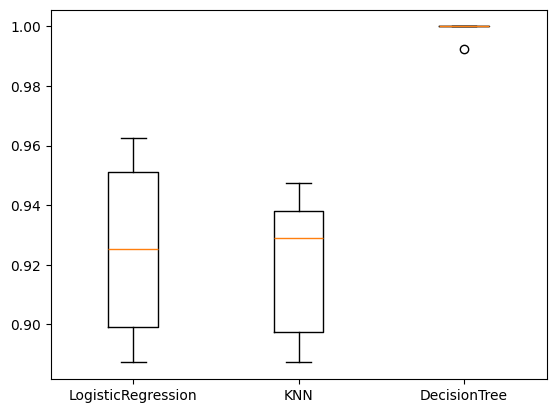

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

X = music.drop("genre", axis=1).values
y = music['genre'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

models = {"LogisticRegression": LogisticRegression(), "KNN":KNeighborsClassifier(), "DecisionTree":DecisionTreeClassifier()}

results = []

for model in models.values():

    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_result = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    results.append(cv_result)

plt.boxplot(results, labels=models.keys())

3